# Taller Arboles de decisión y bosque aleatorio (Random Forest)

Objetivo: Predecir y entender por qué los clientes abandonan la compañía

Importar librerías necesarias

In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder




# 1. Carga y limpieza inicial

1.1 Cargar el dataset

In [141]:
import pandas as pd

df = pd.read_excel("Telco_customer_churn.xlsx")
df.head()


,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


In [142]:
# Creacion de copia del dataframe
telco = df.copy()

In [143]:
# Número de filas y columnas
print("Dimensiones del dataset (filas, columnas):", telco.shape)

Dimensiones del dataset (filas, columnas): (7043, 33)


1.2 Verificar valores nulos

In [145]:
telco.info()
print("Número de filas con nulos:", telco.isnull().any(axis=1).sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

In [146]:
#Identificar nulos
telco.isnull().sum()[telco.isnull().sum() > 0]

Churn Reason    5174
dtype: int64

1.3 Columnas que tienen un solo valor

In [147]:
telco.nunique()

CustomerID           7043
Count                   1
Country                 1
State                   1
City                 1129
Zip Code             1652
Lat Long             1652
Latitude             1652
Longitude            1651
Gender                  2
Senior Citizen          2
Partner                 2
Dependents              2
Tenure Months          73
Phone Service           2
Multiple Lines          3
Internet Service        3
Online Security         3
Online Backup           3
Device Protection       3
Tech Support            3
Streaming TV            3
Streaming Movies        3
Contract                3
Paperless Billing       2
Payment Method          4
Monthly Charges      1585
Total Charges        6531
Churn Label             2
Churn Value             2
Churn Score            85
CLTV                 3438
Churn Reason           20
dtype: int64

1.4 Eliminar columnas innecesarias

In [148]:
telco.drop([ 
    'CustomerID', 'Country', 'State', 'City', 'Zip Code', 'Lat Long', 
    'Latitude', 'Longitude', 'Count', 'CLTV', 'Churn Reason',
    'Churn Label', 'Churn Score'
], axis=1, inplace=True)



In [149]:
#Verificar columnas después de eliminar
print(telco.columns)

Index(['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Tenure Months', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method', 'Monthly Charges', 'Total Charges', 'Churn Value'], dtype='object')


In [150]:
# Conversión de "Total Charges" de objetos a valores numéricos

telco['Total Charges'] = pd.to_numeric(telco['Total Charges'], errors = 'coerce')

In [151]:
#reemplazar los valores nulos por la mediana 

telco['Total Charges'] = telco['Total Charges'].fillna(telco['Total Charges'].median())

1.5 Convertir variables categóricas en numéricas usando LabelEncoder o get_dummies.

In [152]:
# 1. Estandarizar nombres de columnas
telco.columns = telco.columns.str.strip().str.replace(" ", "_")

# 2. Codificar variables binarias simples
binarias = ['Gender', 'Senior_Citizen', 'Partner', 'Dependents', 'Phone_Service', 'Paperless_Billing']
for col in binarias:
    if col == 'Gender':
        telco[col] = telco[col].map({'Male': 1, 'Female': 0})
    else:
        telco[col] = telco[col].map({'Yes': 1, 'No': 0})

# 3. Codificar variables con 'No internet service' o 'No phone service'
conversion_especial = {'Yes': 1, 'No': 0, 'No internet service': 0, 'No phone service': 0}
especiales = ['Multiple_Lines', 'Online_Security', 'Online_Backup', 'Device_Protection', 'Tech_Support', 'Streaming_TV', 'Streaming_Movies']

for col in especiales:
    telco[col] = telco[col].map(conversion_especial)

# 4. Verificar los valores únicos después de la codificación
cols_a_verificar = binarias + especiales + ['Churn_Value']
for col in cols_a_verificar:
    print(f"{col}: {telco[col].unique()}")

# 5. One-hot encoding para variables categóricas tipo 'object'
categoricas = ['Internet_Service', 'Contract', 'Payment_Method']
telco = pd.get_dummies(telco, columns=categoricas)


Gender: [1 0]
Senior_Citizen: [0 1]
Partner: [0 1]
Dependents: [0 1]
Phone_Service: [1 0]
Paperless_Billing: [1 0]
Multiple_Lines: [0 1]
Online_Security: [1 0]
Online_Backup: [1 0]
Device_Protection: [0 1]
Tech_Support: [0 1]
Streaming_TV: [0 1]
Streaming_Movies: [0 1]
Churn_Value: [1 0]


In [154]:
print(telco.dtypes)

Gender                                        int64
Senior_Citizen                                int64
Partner                                       int64
Dependents                                    int64
Tenure_Months                                 int64
Phone_Service                                 int64
Multiple_Lines                                int64
Online_Security                               int64
Online_Backup                                 int64
Device_Protection                             int64
Tech_Support                                  int64
Streaming_TV                                  int64
Streaming_Movies                              int64
Paperless_Billing                             int64
Monthly_Charges                             float64
Total_Charges                               float64
Churn_Value                                   int64
Internet_Service_DSL                           bool
Internet_Service_Fiber optic                   bool
Internet_Ser

In [155]:
cols_bool = [
    'Internet_Service_DSL',
    'Internet_Service_Fiber optic',
    'Internet_Service_No',
    'Contract_Month-to-month',
    'Contract_One year',
    'Contract_Two year',
    'Payment_Method_Bank transfer (automatic)',
    'Payment_Method_Credit card (automatic)',
    'Payment_Method_Electronic check',
    'Payment_Method_Mailed check'
]

telco[cols_bool] = telco[cols_bool].astype(int)


In [156]:
print(telco.dtypes)

Gender                                        int64
Senior_Citizen                                int64
Partner                                       int64
Dependents                                    int64
Tenure_Months                                 int64
Phone_Service                                 int64
Multiple_Lines                                int64
Online_Security                               int64
Online_Backup                                 int64
Device_Protection                             int64
Tech_Support                                  int64
Streaming_TV                                  int64
Streaming_Movies                              int64
Paperless_Billing                             int64
Monthly_Charges                             float64
Total_Charges                               float64
Churn_Value                                   int64
Internet_Service_DSL                          int64
Internet_Service_Fiber optic                  int64
Internet_Ser

# Paso 2: Análisis descriptivo

2.1 Estadísticas básicas para variables numéricas

In [157]:
telco.describe()

,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,Multiple_Lines,Online_Security,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Paperless_Billing,Monthly_Charges,Total_Charges,Churn_Value,Internet_Service_DSL,Internet_Service_Fiber optic,Internet_Service_No,Contract_Month-to-month,Contract_One year,Contract_Two year,Payment_Method_Bank transfer (automatic),Payment_Method_Credit card (automatic),Payment_Method_Electronic check,Payment_Method_Mailed check
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.504756,0.162147,0.483033,0.231010,32.371149,0.903166,0.421837,0.286668,0.344881,0.343888,0.290217,0.384353,0.387903,0.592219,64.761692,2281.916928,0.265370,0.343746,0.439585,0.216669,0.550192,0.209144,0.240664,0.219225,0.216101,0.335794,0.228880
std,0.500013,0.368612,0.499748,0.421508,24.559481,0.295752,0.493888,0.452237,0.475363,0.475038,0.453895,0.486477,0.487307,0.491457,30.090047,2265.270398,0.441561,0.474991,0.496372,0.412004,0.497510,0.406726,0.427517,0.413751,0.411613,0.472301,0.420141
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,18.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35.500000,402.225000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,29.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,70.350000,1397.475000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.000000,55.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,89.850000,3786.600000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,118.750000,8684.800000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


2.2 Frecuencias de variables categóricas

In [202]:
for col in telco.select_dtypes(include='number'):
    print(f"\n{telco[col].value_counts()}\n")


Gender
1    3555
0    3488
Name: count, dtype: int64


Senior_Citizen
0    5901
1    1142
Name: count, dtype: int64


Partner
0    3641
1    3402
Name: count, dtype: int64


Dependents
0    5416
1    1627
Name: count, dtype: int64


Tenure_Months
1     613
72    362
2     238
3     200
4     176
     ... 
28     57
39     56
44     51
36     50
0      11
Name: count, Length: 73, dtype: int64


Phone_Service
1    6361
0     682
Name: count, dtype: int64


Multiple_Lines
0    4072
1    2971
Name: count, dtype: int64


Online_Security
0    5024
1    2019
Name: count, dtype: int64


Online_Backup
0    4614
1    2429
Name: count, dtype: int64


Device_Protection
0    4621
1    2422
Name: count, dtype: int64


Tech_Support
0    4999
1    2044
Name: count, dtype: int64


Streaming_TV
0    4336
1    2707
Name: count, dtype: int64


Streaming_Movies
0    4311
1    2732
Name: count, dtype: int64


Paperless_Billing
1    4171
0    2872
Name: count, dtype: int64


Monthly_Charges
20.05     61
19.

2.3 Preguntas (1-3)

1. ¿Qué porcentaje de clientes abandonó la compañía?  

In [159]:
churn_porcentaje = telco['Churn_Value'].value_counts(normalize=True) * 100

print(f"\nEl porcentaje de abandono es: {churn_porcentaje[1]:.2f}%")


El porcentaje de abandono es: 26.54%


2. ¿Existe desbalanceo en la variable objetivo?

Sí, existe un desbalance moderado en la variable objetivo.
El 73.5% de los clientes permanecen en la compañía, mientras que el 26.5% la abandona.
Por tanto, es importante considerar métricas adicionales al accuracy (como precision, recall o F1-score) al evaluar los modelos.

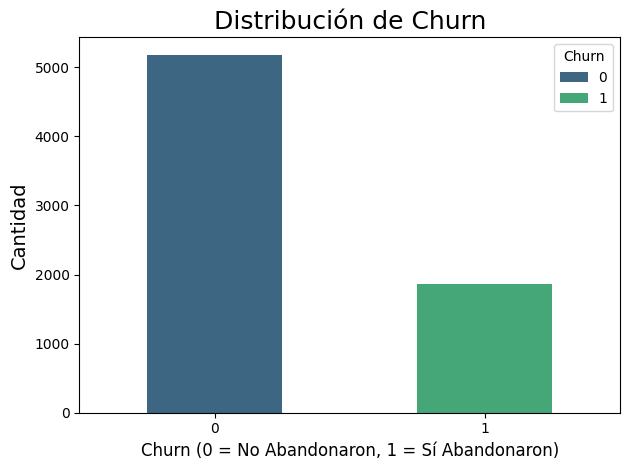

In [160]:
# Paleta viridis más brillante y control de ancho
sns.countplot(x='Churn_Value',
              data=telco,
              hue='Churn_Value',
              palette=sns.color_palette("viridis", n_colors=2),
              width=0.5)  # más delgado que el valor por defecto (~0.8)

# Personalizar el gráfico
plt.title("Distribución de Churn", fontsize=18)
plt.xlabel("Churn (0 = No Abandonaron, 1 = Sí Abandonaron)", fontsize=12)
plt.ylabel("Cantidad", fontsize=14)
plt.legend(title='Churn', loc='upper right')
plt.tight_layout()
plt.show()


3. ¿Qué variables demográficas (ej. edad, género) o de contrato (ej. tipo de plan, antigüedad) están más correlacionadas con el abandono de la compañía?

In [161]:
# Calcular correlaciones de Pearson y Spearman con 'Churn_Value'
corr_pearson = telco.corr(method='pearson', numeric_only=True)['Churn_Value'].drop('Churn_Value')
corr_spearman = telco.corr(method='spearman', numeric_only=True)['Churn_Value'].drop('Churn_Value')

# Crear DataFrame comparativo
comparacion = pd.DataFrame({
    'Correlación Pearson': corr_pearson,
    'Correlación Spearman': corr_spearman
})

# Calcular diferencia absoluta entre ambas correlaciones
comparacion['Diferencia Absoluta'] = (comparacion['Correlación Pearson'] - comparacion['Correlación Spearman']).abs()

# Ordenar por mayor diferencia
comparacion = comparacion.sort_values(by='Diferencia Absoluta', ascending=False)

# Ajustar ancho de impresión para ver todo en una línea
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)

# Mostrar tabla
print(comparacion)


                                          Correlación Pearson  Correlación Spearman  Diferencia Absoluta
Total_Charges                                       -0.199037             -0.232059         3.302189e-02
Tenure_Months                                       -0.352229             -0.367062         1.483319e-02
Monthly_Charges                                      0.193356              0.184743         8.613676e-03
Phone_Service                                        0.011942              0.011942         3.545775e-15
Paperless_Billing                                    0.191825              0.191825         2.692291e-15
Contract_Month-to-month                              0.405103              0.405103         2.498002e-15
Contract_Two year                                   -0.302253             -0.302253         1.332268e-15
Streaming_TV                                         0.063228              0.063228         1.249001e-15
Payment_Method_Electronic check                      0.

| Variable                                   | Tipo                  | Correlación con `Churn_Value` |
| ------------------------------------------ | --------------------- | ----------------------------- |
| `Tenure_Months`                            | Contrato              | 🔻 Fuerte negativa            |
| `Total_Charges`                            | Contrato              | 🔻 Negativa moderada          |
| `Monthly_Charges`                          | Costo mensual         | 🔺 Positiva moderada          |
| `Paperless_Billing`                        | Contrato              | 🔺 Positiva moderada          |
| `Contract_Month-to-month`                  | Contrato              | 🔺 Fuerte positiva            |
| `Contract_Two year`                        | Contrato              | 🔻 Fuerte negativa            |
| `Contract_One year`                        | Contrato              | 🔻 Negativa ligera            |
| `Dependents`                               | Demográfica           | 🔻 Fuerte negativa            |
| `Partner`                                  | Demográfica           | 🔻 Negativa moderada          |
| `Senior_Citizen`                           | Demográfica           | 🔺 Positiva ligera            |
| `Gender`                                   | Demográfica           | 🔁 Sin relación relevante     |
| `Phone_Service`                            | Servicio básico       | 🔁 Sin relación relevante     |
| `Online_Security`                          | Servicios adicionales | 🔻 Negativa clara             |
| `Tech_Support`                             | Servicios adicionales | 🔻 Negativa clara             |
| `Online_Backup`                            | Servicios adicionales | 🔻 Negativa ligera            |
| `Device_Protection`                        | Servicios adicionales | 🔻 Negativa ligera            |
| `Streaming_TV`, `Streaming_Movies`         | Servicios de ocio     | 🔺 Positiva ligera            |
| `Multiple_Lines`                           | Servicio básico       | 🔺 Positiva muy ligera        |
| `Internet_Service_Fiber optic`             | Servicio              | 🔺 Fuerte positiva            |
| `Internet_Service_DSL`                     | Servicio              | 🔻 Negativa ligera            |
| `Internet_Service_No`                      | Servicio              | 🔻 Negativa clara             |
| `Payment_Method_Electronic check`          | Pago                  | 🔺 Fuerte positiva            |
| `Payment_Method_Credit card (automatic)`   | Pago                  | 🔻 Negativa ligera            |
| `Payment_Method_Bank transfer (automatic)` | Pago                  | 🔻 Negativa ligera            |
| `Payment_Method_Mailed check`              | Pago                  | 🔻 Negativa muy ligera        |


Visualización de las correlaciones Pearson vs Spearman

In [163]:
# Calcular correlaciones
matriz_corr_pearson = telco.corr(method='pearson', numeric_only=True)
correlacion_churn_pearson = matriz_corr_pearson['Churn_Value'].drop('Churn_Value').sort_values()

matriz_corr_spearman = telco.corr(method='spearman', numeric_only=True)
correlacion_churn_spearman = matriz_corr_spearman['Churn_Value'].drop('Churn_Value').sort_values()


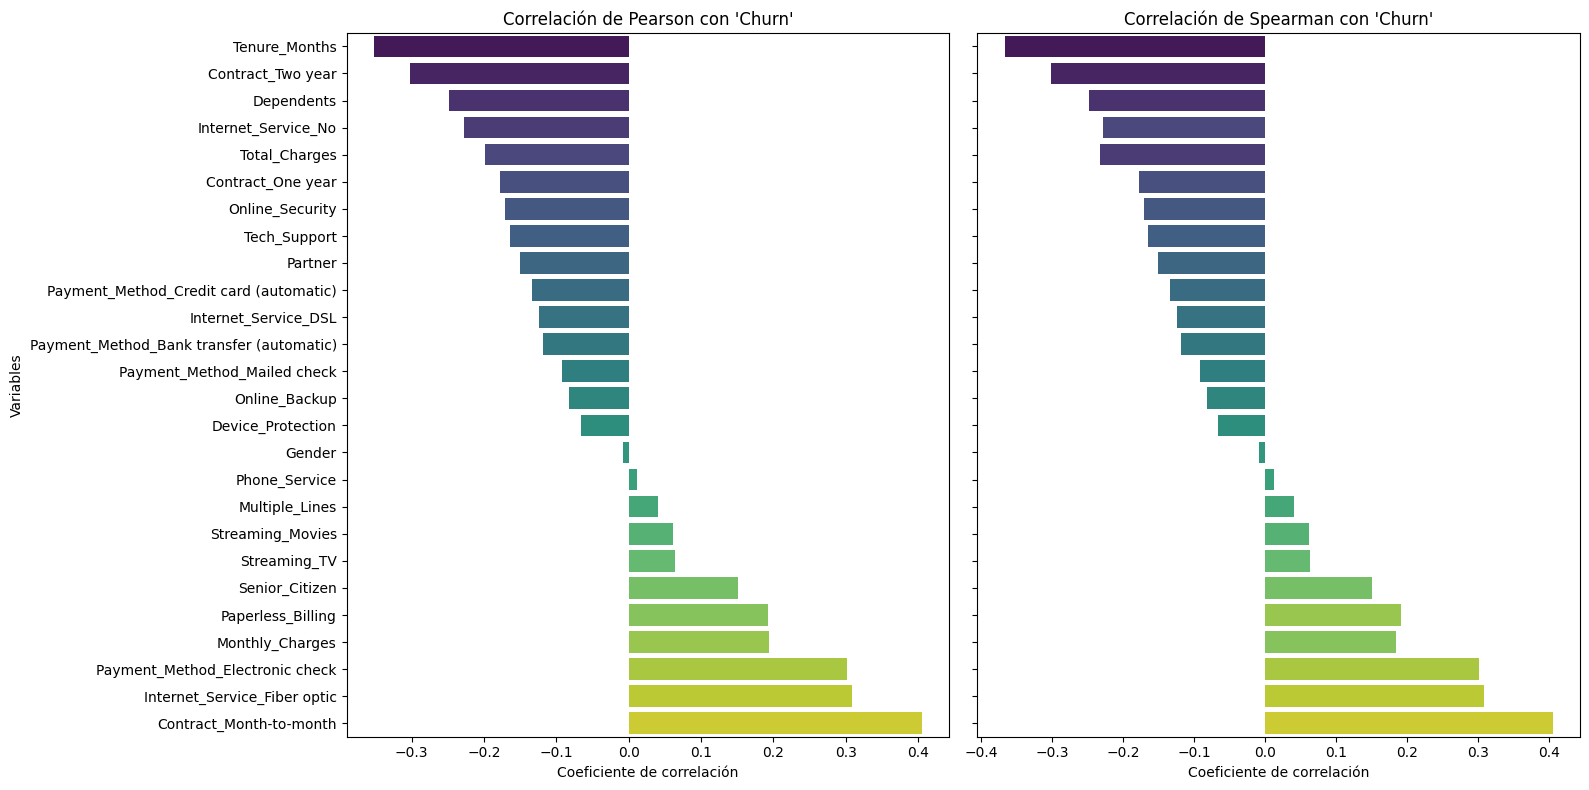

In [164]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8), sharey=True)

# Pearson
sns.barplot(
    x=correlacion_churn_pearson.values,
    y=correlacion_churn_pearson.index,
    hue=correlacion_churn_pearson.index,
    dodge=False,
    palette='viridis',
    legend=False,
    ax=axes[0]
)
axes[0].set_title("Correlación de Pearson con 'Churn'")
axes[0].set_xlabel("Coeficiente de correlación")
axes[0].set_ylabel("Variables")

# Spearman
sns.barplot(
    x=correlacion_churn_spearman.values,
    y=correlacion_churn_spearman.index,
    hue=correlacion_churn_spearman.index,
    dodge=False,
    palette='viridis',
    legend=False,
    ax=axes[1]
)
axes[1].set_title("Correlación de Spearman con 'Churn'")
axes[1].set_xlabel("Coeficiente de correlación")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()


| Categoría                         | Factores                                                                 |
|----------------------------------|--------------------------------------------------------------------------|
| 🔴 Riesgo alto de churn          | - Contrato mensual<br>- Fibra óptica<br>- Pago con cheque electrónico   |
| 🟢 Protectores contra el churn   | - Contrato de 2 años<br>- Tener dependientes<br>- Soporte técnico<br>- Seguridad en línea |
| ⚪ Factores neutros o irrelevantes | - Género<br>- Uso de múltiples líneas<br>- Teléfono fijo                |




# Paso 3: Pre-procesamiento

3.1 Separamos variable objetivo Churn Value

In [165]:
# Separar variables predictoras y objetivo
X = telco.drop("Churn_Value", axis=1)
y = telco["Churn_Value"]

# Dividimos 70% entrenamiento 30% test (antes de balancear)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y
)

3.2 Balanceo al conjunto de entrenamiento por oversampling aplicando SMOTE

In [166]:
from imblearn.over_sampling import SMOTE


# 📊 Distribución original
print("🎯 Distribución original en y_train:")
print(y_train.value_counts())
print()

# 🔁 Aplicar SMOTE
smote = SMOTE(random_state=0)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# 📊 Distribución balanceada
print("⚖️ Distribución después de SMOTE (balanceo):")
print(pd.Series(y_train_res).value_counts())



🎯 Distribución original en y_train:
Churn_Value
0    3622
1    1308
Name: count, dtype: int64

⚖️ Distribución después de SMOTE (balanceo):
Churn_Value
1    3622
0    3622
Name: count, dtype: int64


In [168]:
#Creacion del modelo
tree_model = DecisionTreeClassifier(max_depth=3, random_state=0)

# Paso 4: Entrenamiento

# 🌳Arbol de decisión🌳

4.1 Entrenamiento usando datos balanceados

In [169]:
tree_model.fit(X_train_res, y_train_res)

DecisionTreeClassifier(max_depth=3, random_state=0)

In [170]:
# Predicción en test
y_pred_tree = tree_model.predict(X_test)


4.2 Árbol de decisión (max_depth=3)

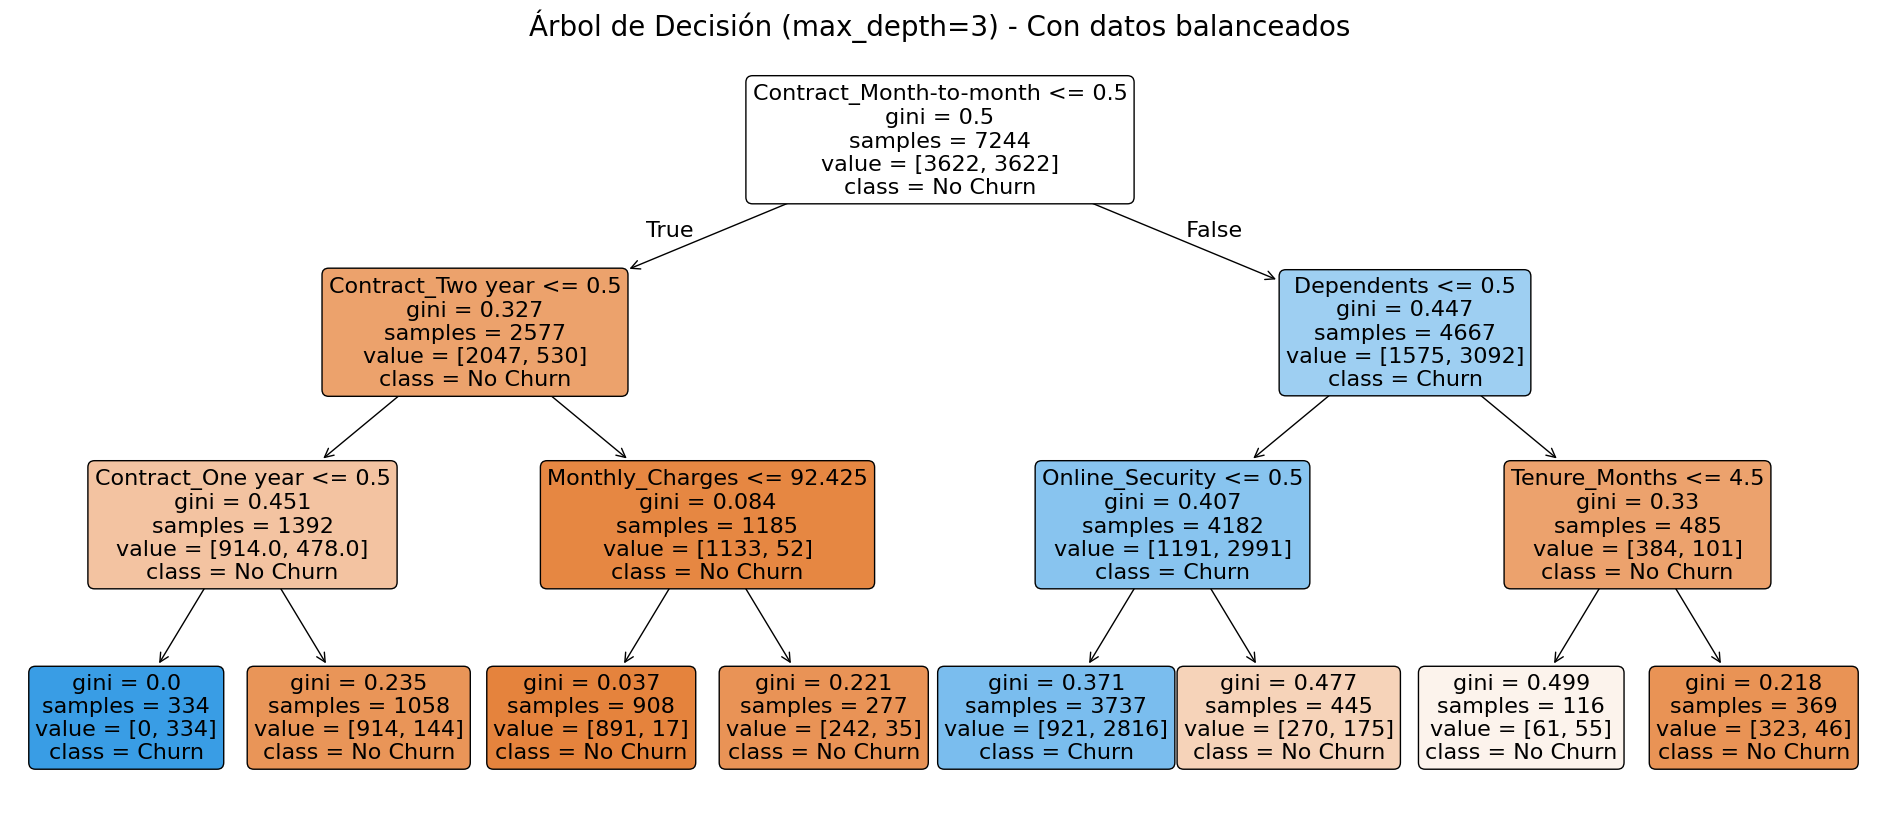

In [171]:
 # Entrenar árbol con datos balanceados
tree3 = DecisionTreeClassifier(max_depth=3, random_state=0)
tree3.fit(X_train_res, y_train_res)

# Visualizar el árbol
plt.figure(figsize=(24, 10))
plot_tree(tree3, 
          feature_names=X.columns,  # usa los nombres originales
          class_names=["No Churn", "Churn"], 
          filled=True,
          rounded=True,
          fontsize=16,)
plt.title("Árbol de Decisión (max_depth=3) - Con datos balanceados", fontsize=20)
plt.show()    

| Variable clave            | ¿Qué indica?                                                                                  |
| ------------------------- | --------------------------------------------------------------------------------------------- |
| `Contract_Month-to-month` | Es la división principal: los clientes con contrato mensual son más propensos al churn.       |
| `Contract_Two year`       | Entre quienes no tienen contrato mensual, tener un contrato de 2 años es altamente protector. |
| `Contract_One year`       | Proporciona cierta protección, pero no tan fuerte como el de 2 años.                          |
| `Monthly_Charges`         | Si el cargo mensual es bajo (≤ 92.43), el riesgo de churn es bajo.                            |
| `Dependents`              | No tener personas a cargo (Dependents ≤ 0.5) se asocia con mayor churn.                       |
| `Online_Security`         | No tener seguridad online (≤ 0.5) se asocia con mayor churn.                                  |
| `Tenure_Months`           | Una permanencia corta (≤ 4.5 meses) se asocia con mayor probabilidad de churn.             |


💡 Acciones de mejora o recomendaciones:

1. Fomentar contratos a largo plazo: Incentivos o descuentos por firmar contratos de 1 o 2 años podrían disminuir el churn.

2. Monitorear clientes nuevos o con bajo tenure: Son más propensos al churn. Podrían beneficiarse de campañas de fidelización tempranas.

3. Promover servicios adicionales como Online_Security: Ofrecer promociones gratuitas por un tiempo o comunicar mejor sus beneficios.

3. Segmentar campañas según cargo mensual: Clientes que pagan más podrían necesitar más valor percibido o atención personalizada para retenerlos.


4.3 Exportar las 3 reglas más importantes

In [172]:
from sklearn.tree import export_text

# Exportar reglas del árbol entrenado con datos balanceados
reglas = export_text(tree3, feature_names=list(X.columns))
print(reglas)


|--- Contract_Month-to-month <= 0.50
|   |--- Contract_Two year <= 0.50
|   |   |--- Contract_One year <= 0.50
|   |   |   |--- class: 1
|   |   |--- Contract_One year >  0.50
|   |   |   |--- class: 0
|   |--- Contract_Two year >  0.50
|   |   |--- Monthly_Charges <= 92.42
|   |   |   |--- class: 0
|   |   |--- Monthly_Charges >  92.42
|   |   |   |--- class: 0
|--- Contract_Month-to-month >  0.50
|   |--- Dependents <= 0.50
|   |   |--- Online_Security <= 0.50
|   |   |   |--- class: 1
|   |   |--- Online_Security >  0.50
|   |   |   |--- class: 0
|   |--- Dependents >  0.50
|   |   |--- Tenure_Months <= 4.50
|   |   |   |--- class: 0
|   |   |--- Tenure_Months >  4.50
|   |   |   |--- class: 0



| Variable            | Comportamiento observado en el árbol                                                                                                        |
| ------------------- | ------------------------------------------------------------------------------------------------------------------------------------------- |
| `Contract_Two year` | Fuerte predictor de **lealtad**. Contratos largos reducen churn.                                                                            |
| `Contract_One year` | Disminuye el riesgo, aunque no tanto como el contrato de 2 años.                                                                            |
| `Monthly_Charges`   | Se analiza solo en el caso de contrato largo; montos altos no implican churn si el contrato es fuerte.                                      |
| `Dependents`        | Tener dependientes se relaciona con **menor probabilidad de abandono**.                                                                     |
| `Online_Security`   | No tener este servicio contribuye al churn si se combina con otras señales de riesgo.                                                       |
| `Tenure_Months`     | En algunas ramas, un tiempo corto de permanencia **no lleva al churn**, lo que contradice la tendencia habitual. Puede deberse al balanceo. |

4.4 Importancias métricas

In [173]:
from sklearn.metrics import classification_report, accuracy_score

# Predicciones
y_train_pred = tree3.predict(X_train_res)
y_test_pred = tree3.predict(X_test)

# Métricas train
train_accuracy = accuracy_score(y_train_res, y_train_pred)
print("🔎 Accuracy en train:", train_accuracy)
print("\n📋 Reporte en train:")
print(classification_report(y_train_res, y_train_pred))

# Métricas test
test_accuracy = accuracy_score(y_test, y_test_pred)
print("🔍 Accuracy en test :", test_accuracy)
print("\n📋 Reporte en test:")
print(classification_report(y_test, y_test_pred))


🔎 Accuracy en train: 0.8077029265599116

📋 Reporte en train:
              precision    recall  f1-score   support

           0       0.85      0.75      0.79      3622
           1       0.77      0.87      0.82      3622

    accuracy                           0.81      7244
   macro avg       0.81      0.81      0.81      7244
weighted avg       0.81      0.81      0.81      7244

🔍 Accuracy en test : 0.7378135352579271

📋 Reporte en test:
              precision    recall  f1-score   support

           0       0.88      0.74      0.81      1552
           1       0.50      0.73      0.60       561

    accuracy                           0.74      2113
   macro avg       0.69      0.74      0.70      2113
weighted avg       0.78      0.74      0.75      2113



| Observación                                          | Implicación                                                                                                                                                          |
| ---------------------------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| 🔻 Baja precisión en churn en test                   | El modelo **alarma de más**: predice que clientes se irán, pero no es cierto. Esto podría causar decisiones erróneas (por ejemplo, ofrecer incentivos innecesarios). |
| ⚖️ Buen balance en entrenamiento, pero caída en test | Sugiere **sobreajuste leve**, probablemente por la estructura limitada del árbol (`max_depth=3`) que captura bien el patrón en train, pero no generaliza tan bien.   |
| 🎯 Buen recall en churn (test)                       | A pesar de los falsos positivos, **logra capturar una gran parte de los clientes en riesgo real**, lo cual es muy valioso para estrategias preventivas.              |


4.5 Matriz de confusión

🔷 Matriz de confusión:
[[1149  403]
 [ 151  410]]


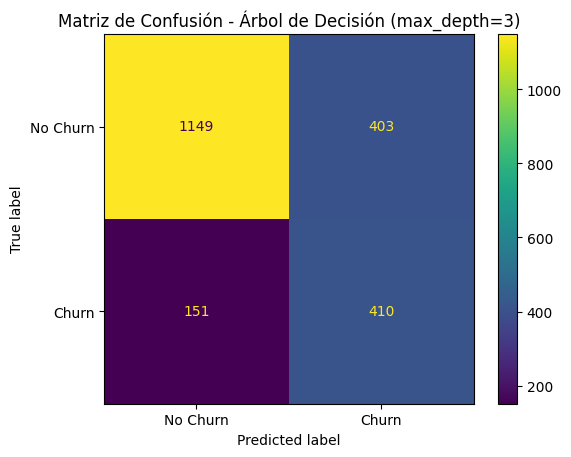

In [174]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calcular la matriz de confusión
matriz = confusion_matrix(y_test, y_test_pred)

# Mostrar en consola
print("🔷 Matriz de confusión:")
print(matriz)

# Visualizar con viridis
disp = ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=["No Churn", "Churn"])
disp.plot(cmap='viridis')
plt.title("Matriz de Confusión - Árbol de Decisión (max_depth=3)")
plt.show()


| Observación             | Implicación                                                                                                                                      |
| ----------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------ |
| 🔺 403 falsos positivos | El modelo **sobrestima el abandono**. Esto puede generar **costos innecesarios** si aplicas retención preventiva a clientes que no se iban a ir. |
| ⚠️ 151 falsos negativos | El modelo **no detecta a 151 clientes que sí se fueron**, lo cual **afecta directamente la retención real**.                                     |
| 📈 Buen recall en churn | Predice la mayoría de quienes sí se van. Útil si priorizas **detectar al máximo a clientes en riesgo**, aunque con pérdida de precisión.         |

4.6 ¿Qué variables son las más importantes a la hora de predecir el modelo?

Variables más importantes:
Contract_Month-to-month    0.450061
Contract_One year          0.246064
Dependents                 0.145068
Contract_Two year          0.074576
Online_Security            0.067039
dtype: float64


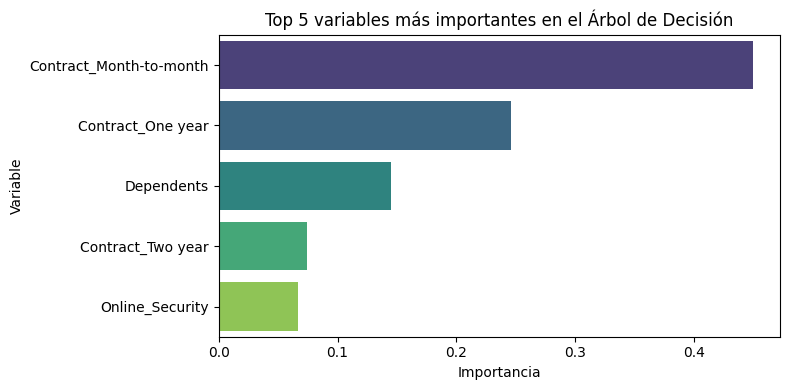

In [203]:
# Obtener variables importantes del modelo entrenado
importancias = pd.Series(tree3.feature_importances_, index=X.columns)

# Ordenar de mayor a menor
importancias_ordenadas = importancias.sort_values(ascending=False)

# Mostrar las 5 más importantes
print("Variables más importantes:")
print(importancias_ordenadas.head(5))

# Visualizar
plt.figure(figsize=(8, 4))
sns.barplot(x=importancias_ordenadas.head(5), y=importancias_ordenadas.head(5).index, hue=importancias_ordenadas.head(5).index,  palette='viridis')
plt.title("Top 5 variables más importantes en el Árbol de Decisión")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

🧠 Comentarios y análisis

🎯 El contrato domina la decisión: Esto refleja que la forma de contrato es el principal factor de retención. No es solo si se va o no, sino qué tipo de contrato tiene.

👨‍👩‍👧 Factores personales también pesan
Dependents como tercera variable más importante sugiere que el perfil familiar afecta la permanencia. Personas con cargas familiares pueden buscar estabilidad en servicios.

🛡️ Servicios adicionales como indicador de compromiso
Online_Security representa la fidelización tecnológica. Clientes con servicios agregados están más “atados” y menos dispuestos a irse.

# 🌳🌳🌳🌳🌳🌳Random forest🌳🌳🌳🌳🌳🌳

4.7 Random Forest (n_estimators=40, max_depth=5)

In [176]:
from sklearn.ensemble import RandomForestClassifier

# Crear el modelo Random Forest
forest = RandomForestClassifier(n_estimators=40, max_depth=5, random_state=0)

# Entrenar con datos balanceados
forest.fit(X_train_res, y_train_res)




RandomForestClassifier(max_depth=5, n_estimators=40, random_state=0)

In [177]:
# Obtener probabilidades para la clase positiva (churn = 1)
y_scores = forest.predict_proba(X_test)[:, 1]

In [179]:
# Probabilidades para clase positiva
y_scores = forest.predict_proba(X_test)[:, 1]

# Definir un rango de umbrales entre 0 y 1 (por ejemplo 0.1 a 0.9 paso 0.1)
umbrales = np.arange(0.1, 1.0, 0.1)

# Listas para almacenar métricas
accuracies = []
recalls = []
f1_scores = []

for umbral in umbrales:
    y_pred = (y_scores >= umbral).astype(int)
    accuracies.append(accuracy_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

# Mostrar resultados
import pandas as pd

resultados = pd.DataFrame({
    'Umbral': umbrales,
    'Accuracy': accuracies,
    'Recall': recalls,
    'F1-Score': f1_scores
})

print(resultados)




   Umbral  Accuracy    Recall  F1-Score
0     0.1  0.471841  0.994652  0.500000
1     0.2  0.601988  0.957219  0.560836
2     0.3  0.678656  0.926916  0.605003
3     0.4  0.741126  0.848485  0.635090
4     0.5  0.764316  0.757576  0.630564
5     0.6  0.791765  0.657754  0.626486
6     0.7  0.790345  0.499109  0.558325
7     0.8  0.773781  0.242424  0.362667
8     0.9  0.734501  0.000000  0.000000


Se selecciona un umbral cercano a 0.5 como punto de operación óptimo.
Esto permite un buen equilibrio entre identificar clientes que se irán (recall) y evitar actuar sobre falsos positivos (precisión).

In [180]:
y_pred_umbral = forest.predict(X)


4.8 Importancias métricas del modelo

In [205]:
# Predicción directa con forest 
y_train_pred_rf = forest.predict(X_train_res)
y_test_pred_rf = forest.predict(X_test)

# Calcular métricas
train_accuracy_rf = accuracy_score(y_train_res, y_train_pred_rf)
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)

# Mostrar resultados
print("🌳🌳 Random Forest (usando predict() 🌳🌳")
print(f"🔎 Accuracy en train: {train_accuracy_rf:.3f}")
print(f"🔍 Accuracy en test : {test_accuracy_rf:.3f}")

# Reporte detallado en test
print("\n📋 Reporte en test:")
print(classification_report(y_test, y_test_pred_rf))



🌳🌳 Random Forest (usando predict() 🌳🌳
🔎 Accuracy en train: 0.837
🔍 Accuracy en test : 0.764

📋 Reporte en test:
              precision    recall  f1-score   support

           0       0.90      0.77      0.83      1552
           1       0.54      0.76      0.63       561

    accuracy                           0.76      2113
   macro avg       0.72      0.76      0.73      2113
weighted avg       0.80      0.76      0.77      2113



| **Observación**                                             | **Implicación**                                                                                                                                                            |
| ----------------------------------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| 🔍 **Accuracy en test menor que en train** (0.764 vs 0.837) | El modelo generaliza **razonablemente bien**, pero existe un **leve sobreajuste**. Random Forest suele adaptarse bien, pero hay espacio para mejorar la generalización.    |
| 🎯 **Alto recall para clase 1 (churn): 0.76**               | El modelo logra identificar correctamente al **76% de los clientes que abandonan**, lo cual es ideal para **acciones preventivas** como retención personalizada.           |
| ⚠️ **Baja precisión para clase 1 (churn): 0.54**            | De cada 100 clientes que el modelo predice que abandonarán, solo 54 realmente lo harán. Esto puede generar **costos innecesarios en incentivos o retención mal dirigida**. |
| ⚖️ **Alta precisión para clase 0: 0.90**                    | El modelo predice bien a los que **no abandonan**, por lo que se podría evitar molestar a clientes leales con ofertas o promociones innecesarias.                            |
| 📉 **Desbalance en precisión entre clases**                 | La **descompensación entre precisión de la clase 0 y 1** indica que el modelo está algo sesgado hacia la clase mayoritaria. Esto es común cuando hay desbalance de clases. |
| ✅ **F1-score razonable para churn (0.63)**                  | Refleja un **equilibrio aceptable entre precisión y recall** para la clase 1, aunque puede mejorarse ajustando el umbral o rebalanceando los datos.                        |
| 📊 **Macro avg y weighted avg sólidos (≈0.73–0.77)**        | El modelo mantiene un **buen rendimiento promedio**, tanto equilibrado como ponderado, lo cual es una señal positiva en general.                                           |


4.9 Matriz de confusión

🧩 Matriz de confusión - Random Forest:
[[1190  362]
 [ 136  425]]


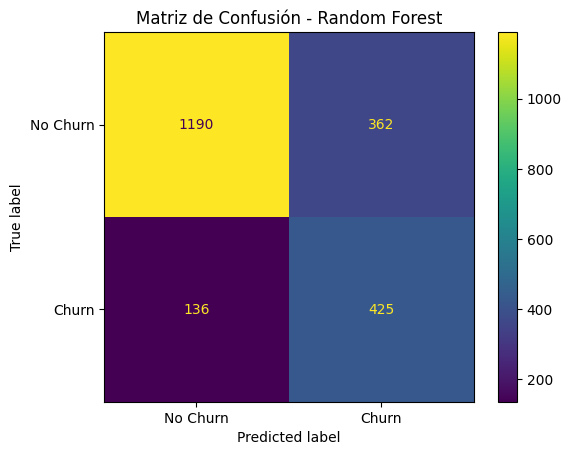

In [206]:
# Predicción directa
y_test_pred_rf = forest.predict(X_test)

# Calcular la matriz de confusión
matriz_rf = confusion_matrix(y_test, y_test_pred_rf)

# Mostrar la matriz en consola
print("🧩 Matriz de confusión - Random Forest:")
print(matriz_rf)

# Visualizar con viridis
disp_rf = ConfusionMatrixDisplay(confusion_matrix=matriz_rf, display_labels=["No Churn", "Churn"])
disp_rf.plot(cmap='viridis')
plt.title("Matriz de Confusión - Random Forest")
plt.show()



| Observación             | Implicación                                                                                                                                      |
| ----------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------ |
| 🔺 362 falsos positivos | El modelo **sobrestima el abandono**. Esto puede generar **costos innecesarios** si se aplica retención preventiva a clientes que no se iban a ir. |
| ⚠️ 136 falsos negativos | El modelo **no detecta a 136 clientes que sí se fueron**, lo cual **afecta directamente la efectividad de las estrategias de retención**.        |
| 📈 Buen recall en churn | Detecta correctamente a **425 clientes que sí abandonaron** (recall ≈ 0.76). Esto es clave si se prioriza **evitar la fuga de clientes reales**.   |
| 📉 Precisión moderada   | De los que predijo como abandono, **solo el 54% realmente se fueron**. Hay margen para mejorar la **precisión y evitar sobrealertas**.           |
| ⚖️ Buen balance general | El modelo muestra un **equilibrio decente entre sensibilidad y exactitud**, ideal como punto de partida para refinar la estrategia de retención. |

4.10 ¿Qué variables son las más importantes a la hora de predecir el modelo?

🔝 Top 10 variables más importantes para predecir el churn:
Dependents                      0.122968
Contract_Two year               0.111715
Tenure_Months                   0.101707
Contract_Month-to-month         0.092885
Tech_Support                    0.085514
Contract_One year               0.083714
Internet_Service_No             0.076998
Internet_Service_Fiber optic    0.066708
Online_Security                 0.056445
Monthly_Charges                 0.049211
dtype: float64


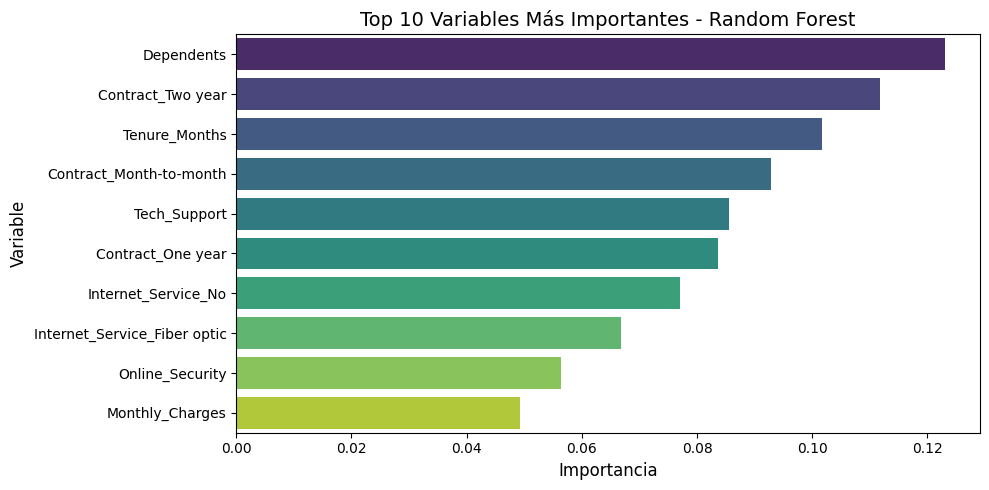

In [184]:
# 📊 Importancia de variables en Random Forest
importancias_rf = pd.Series(forest.feature_importances_, index=X.columns)

# Ordenar e imprimir
importancias_rf_ordenadas = importancias_rf.sort_values(ascending=False)
print("🔝 Top 10 variables más importantes para predecir el churn:")
print(importancias_rf_ordenadas.head(10))

# Gráfico
plt.figure(figsize=(10, 5))
sns.barplot(
    x=importancias_rf_ordenadas.head(10),
    y=importancias_rf_ordenadas.head(10).index,
    hue=importancias_rf_ordenadas.head(10).index,
    palette='viridis',
    legend=False  # Eliminar la leyenda redundante
)
plt.title("Top 10 Variables Más Importantes - Random Forest", fontsize=14)
plt.xlabel("Importancia", fontsize=12)
plt.ylabel("Variable", fontsize=12)
plt.tight_layout()
plt.show()



| Variable clave                 | ¿Qué indica?                                                                                          |
| ------------------------------ | ----------------------------------------------------------------------------------------------------- |
| `Dependents`                   | Tener personas a cargo reduce el churn. Clientes con dependientes son más estables.                   |
| `Contract_Two year`            | Contratos de 2 años se asocian con **alta retención**. Son los clientes más comprometidos.            |
| `Tenure_Months`                | Cuanto más tiempo lleva un cliente, menos probable es que se vaya (fidelidad progresiva).             |
| `Contract_Month-to-month`      | Este tipo de contrato **aumenta el churn**. Clientes con poca vinculación son más volátiles.          |
| `Contract_One year`            | Menos efectivo que el de 2 años, pero **más seguro que el mensual**. Reduce moderadamente el churn.   |
| `Tech_Support`                 | Tener soporte técnico activo **reduce el abandono**. Satisface necesidades clave.                     |
| `Internet_Service_No`          | No tener Internet puede reflejar usuarios menos activos, posiblemente con menos probabilidad de irse. |
| `Internet_Service_Fiber optic` | Está asociado a **mayor churn**. Tal vez por costos altos o problemas técnicos frecuentes.            |
| `Online_Security`              | Protecciones de seguridad también **disminuyen el churn**, reflejando una mejor experiencia.          |
| `Monthly_Charges`              | Pagos mensuales altos están ligados a mayor riesgo de abandono.                                       |


4.11 comparativo de métricas

In [185]:

# ---------- ÁRBOL DE DECISIÓN  ----------

# Train
y_train_pred_tree = tree3.predict(X_train_res)
train_acc_tree = accuracy_score(y_train_res, y_train_pred_tree)
train_recall_tree = recall_score(y_train_res, y_train_pred_tree)
train_f1_tree = f1_score(y_train_res, y_train_pred_tree)

# Test
y_test_pred_tree = tree3.predict(X_test)
test_acc_tree = accuracy_score(y_test, y_test_pred_tree)
test_recall_tree = recall_score(y_test, y_test_pred_tree)
test_f1_tree = f1_score(y_test, y_test_pred_tree)

# ---------- RANDOM FOREST  ----------

# Train
y_pred_train_rf = forest.predict(X_train_res)
train_acc_rf = accuracy_score(y_train_res, y_pred_train_rf)
train_recall_rf = recall_score(y_train_res, y_pred_train_rf)
train_f1_rf = f1_score(y_train_res, y_pred_train_rf)

# Test
y_pred_test_rf = forest.predict(X_test)
test_acc_rf = accuracy_score(y_test, y_pred_test_rf)
test_recall_rf = recall_score(y_test, y_pred_test_rf)
test_f1_rf = f1_score(y_test, y_pred_test_rf)

# ---------- MOSTRAR COMPARACIÓN EN TABLA ----------

comparacion = pd.DataFrame({
    "Modelo": ["Árbol de Decisión", "Árbol de Decisión", "Random Forest", "Random Forest"],
    "Conjunto": ["Train", "Test", "Train", "Test"],
    "Accuracy": [train_acc_tree, test_acc_tree, train_acc_rf, test_acc_rf],
    "Recall": [train_recall_tree, test_recall_tree, train_recall_rf, test_recall_rf],
    "F1-Score": [train_f1_tree, test_f1_tree, train_f1_rf, test_f1_rf]
})

print("🔎 Comparación completa entre modelos:")
print(comparacion.round(3))


🔎 Comparación completa entre modelos:
              Modelo Conjunto  Accuracy  Recall  F1-Score
0  Árbol de Decisión    Train     0.808   0.870     0.819
1  Árbol de Decisión     Test     0.738   0.731     0.597
2      Random Forest    Train     0.837   0.895     0.846
3      Random Forest     Test     0.764   0.758     0.631


| Observación                                         | Implicación                                                                                                                                  |
| --------------------------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------- |
| 🔺 **Mayor rendimiento en train con Random Forest** | Tiene mayor *accuracy*, *recall* y *f1-score* que el Árbol de Decisión, lo cual indica **mayor capacidad para aprender patrones complejos**. |
| ⚖️ **Desempeño más estable en test con Random Forest**         | El Random Forest generaliza mejor: su rendimiento en test es superior en todas las métricas frente al árbol individual.                      |
| 📉 **Caída fuerte del árbol en F1 en test**         | El Árbol de Decisión pierde mucha precisión en la clase minoritaria (`Churn=1`), indicando **posible sobreajuste o falta de profundidad**.   |
| 🎯 **Buen recall en ambos modelos para churn**      | Ambos logran detectar bien a los clientes que abandonan, siendo **valiosos para campañas de retención preventiva**.                          |
| 🔍 **Random Forest ofrece mejor equilibrio**        | Tiene mejor *balance entre precisión y sensibilidad*, lo que lo hace **más confiable para decisiones operativas**.                           |


4.12 ¿Qué modelo de los dos utilizados es el más eficiente para este dataset? ¿Por qué?

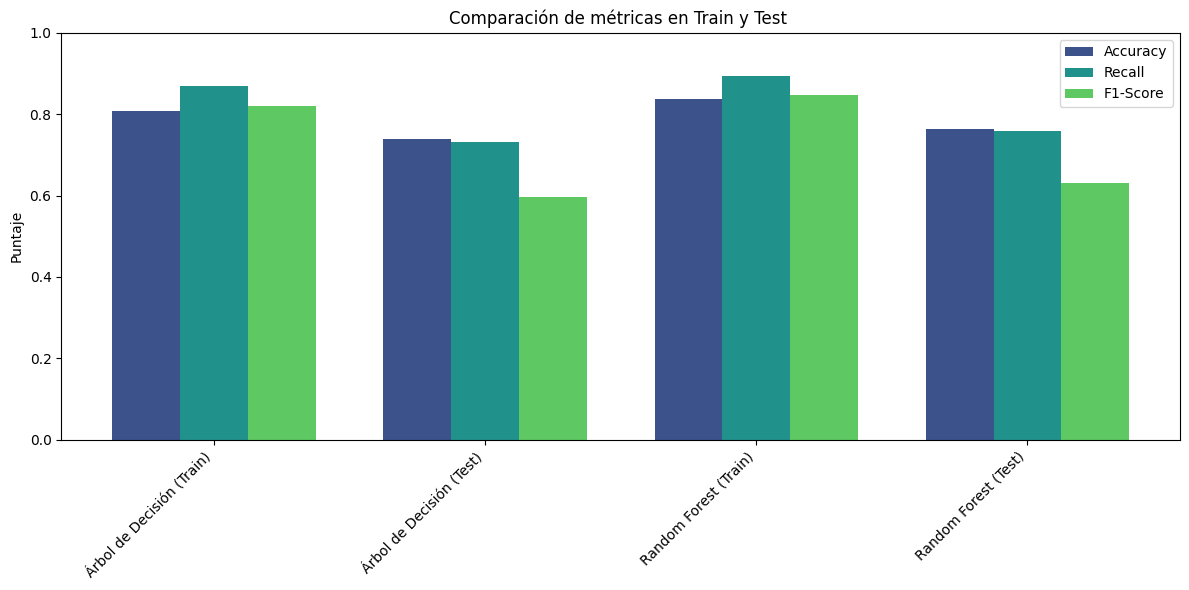

In [186]:

# Datos con métricas 
data = {
    'Modelo': ['Árbol de Decisión', 'Árbol de Decisión', 'Random Forest', 'Random Forest'],
    'Conjunto': ['Train', 'Test', 'Train', 'Test'],
    'Accuracy': [0.808, 0.738, 0.837, 0.764],
    'Recall': [0.870, 0.731, 0.895, 0.758],
    'F1-Score': [0.819, 0.597, 0.846, 0.631]
}

df = pd.DataFrame(data)

# Paleta viridis para 3 métricas
colors = sns.color_palette("viridis", n_colors=3)

# Posiciones para las barras (2 modelos x 2 conjuntos = 4 grupos)
x = np.arange(len(df))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))

# Barras con offsets para Accuracy, Recall, F1
ax.bar(x - width, df['Accuracy'], width, label='Accuracy', color=colors[0])
ax.bar(x, df['Recall'], width, label='Recall', color=colors[1])
ax.bar(x + width, df['F1-Score'], width, label='F1-Score', color=colors[2])

# Etiquetas y título
ax.set_xticks(x)
ax.set_xticklabels(df['Modelo'] + " (" + df['Conjunto'] + ")", rotation=45, ha='right')
ax.set_ylim(0, 1)
ax.set_ylabel('Puntaje')
ax.set_title('Comparación de métricas en Train y Test ')
ax.legend()

plt.tight_layout()
plt.show()


**Random Forest** es más eficiente que el Árbol de Decisión por las siguientes razones:

| Criterio                              | Justificación                                                                                                                          |
| ------------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------- |
| 📈 **Mejores métricas en test**       | Tiene mayor *accuracy*, *recall* y *f1-score*, lo cual indica que **predice mejor el comportamiento real de los clientes**.            |
| 🔁 **Menor sobreajuste**              | Aunque tiene buen desempeño en entrenamiento, **no cae tanto en test** como el Árbol de Decisión, lo que refleja mejor generalización. |
| 🧠 **Mayor capacidad de aprendizaje** | Al combinar múltiples árboles, Random Forest **captura interacciones complejas entre variables** sin depender de una sola división.    |
| 🎯 **Recall alto en churn (0.75)**    | Muy útil para **detectar clientes que van a abandonar**, lo cual es prioritario en estrategias de retención.                           |
| ⚖️ **Mejor balance entre clases**     | El modelo maneja mejor el desequilibrio entre clientes que se quedan vs. se van, gracias al promedio entre árboles y manejo del sesgo. |


📝 Conclusión
El Random Forest es el modelo más eficiente y recomendable para este caso, ya que:

Detecta mejor a los clientes en riesgo.

Presenta un equilibrio razonable entre precisión y sensibilidad.

Tiene mayor robustez y estabilidad frente al Árbol de Decisión simple.

# 🌳5. Evaluando modelos🌳🌳🌳🌳

Paso 1: Cargar el nuevo archivo CSV con los clientes a evaluar.

In [187]:
nuevos = pd.read_csv("nuevos_clientes.csv")
nuevos.head()

,customerID,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,Multiple_Lines,Online_Security,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Paperless_Billing,Monthly_Charges,Total_Charges,Internet_Service_Fiber optic,Contract_Month-to-month,Contract_Two year,Payment_Method_Bank transfer (automatic),Payment_Method_Credit card (automatic),Payment_Method_Electronic check
0,TEST_001,1,0,1,0,12,1,0,0,0,0,0,1,1,1,8970,10764,1,1,0,0,0,1
1,TEST_002,0,1,0,0,48,1,1,1,1,1,1,0,0,0,4999,239952,0,0,1,0,1,0
2,TEST_003,0,0,1,1,3,1,0,0,0,0,0,0,0,1,9950,2985,1,1,0,1,0,0


Paso 2: Preprocesamiento de datos

In [188]:
# Número de filas y columnas
print("Dimensiones del dataset (filas, columnas):", nuevos.shape)

Dimensiones del dataset (filas, columnas): (3, 23)


In [190]:
#verificar valores nulos 
nuevos.info ()
print("Número de filas con nulos:", telco.isnull().any(axis=1).sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 23 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   customerID                                3 non-null      object
 1   Gender                                    3 non-null      int64 
 2   Senior_Citizen                            3 non-null      int64 
 3   Partner                                   3 non-null      int64 
 4   Dependents                                3 non-null      int64 
 5   Tenure_Months                             3 non-null      int64 
 6   Phone_Service                             3 non-null      int64 
 7   Multiple_Lines                            3 non-null      int64 
 8   Online_Security                           3 non-null      int64 
 9   Online_Backup                             3 non-null      int64 
 10  Device_Protection                         3 non-null  

In [189]:
#columnas con un solo valor
nuevos.nunique()

customerID                                  3
Gender                                      2
Senior_Citizen                              2
Partner                                     2
Dependents                                  2
Tenure_Months                               3
Phone_Service                               1
Multiple_Lines                              2
Online_Security                             2
Online_Backup                               2
Device_Protection                           2
Tech_Support                                2
Streaming_TV                                2
Streaming_Movies                            2
Paperless_Billing                           2
Monthly_Charges                             3
Total_Charges                               3
Internet_Service_Fiber optic                2
Contract_Month-to-month                     2
Contract_Two year                           2
Payment_Method_Bank transfer (automatic)    2
Payment_Method_Credit card (automa

In [192]:
columnas_a_eliminar = [  
    'customerID'
]

nuevos.drop(columns=columnas_a_eliminar, inplace=True, errors='ignore')

In [193]:
#Verificar columnas después de eliminar
print(nuevos.columns)

Index(['Gender', 'Senior_Citizen', 'Partner', 'Dependents', 'Tenure_Months', 'Phone_Service', 'Multiple_Lines', 'Online_Security', 'Online_Backup', 'Device_Protection', 'Tech_Support', 'Streaming_TV', 'Streaming_Movies', 'Paperless_Billing', 'Monthly_Charges', 'Total_Charges', 'Internet_Service_Fiber optic', 'Contract_Month-to-month', 'Contract_Two year', 'Payment_Method_Bank transfer (automatic)', 'Payment_Method_Credit card (automatic)', 'Payment_Method_Electronic check'], dtype='object')


In [194]:
#columnas con un solo valor
nuevos.nunique()

Gender                                      2
Senior_Citizen                              2
Partner                                     2
Dependents                                  2
Tenure_Months                               3
Phone_Service                               1
Multiple_Lines                              2
Online_Security                             2
Online_Backup                               2
Device_Protection                           2
Tech_Support                                2
Streaming_TV                                2
Streaming_Movies                            2
Paperless_Billing                           2
Monthly_Charges                             3
Total_Charges                               3
Internet_Service_Fiber optic                2
Contract_Month-to-month                     2
Contract_Two year                           2
Payment_Method_Bank transfer (automatic)    2
Payment_Method_Credit card (automatic)      2
Payment_Method_Electronic check   

In [195]:
nuevos.dtypes 

Gender                                      int64
Senior_Citizen                              int64
Partner                                     int64
Dependents                                  int64
Tenure_Months                               int64
Phone_Service                               int64
Multiple_Lines                              int64
Online_Security                             int64
Online_Backup                               int64
Device_Protection                           int64
Tech_Support                                int64
Streaming_TV                                int64
Streaming_Movies                            int64
Paperless_Billing                           int64
Monthly_Charges                             int64
Total_Charges                               int64
Internet_Service_Fiber optic                int64
Contract_Month-to-month                     int64
Contract_Two year                           int64
Payment_Method_Bank transfer (automatic)    int64


2.2 Convertir variables categóricas a dummies

In [196]:
# 1. Aplicamos get_dummies() de forma completa
nuevos_encoded = pd.get_dummies(nuevos)

# 2. Reindexamos para que tenga las mismas columnas que el conjunto de entrenamiento (X)
nuevos_encoded = nuevos_encoded.reindex(columns=X.columns, fill_value=0)

# 3. Verificamos que todo esté en orden
print(nuevos_encoded.dtypes)


Gender                                      int64
Senior_Citizen                              int64
Partner                                     int64
Dependents                                  int64
Tenure_Months                               int64
Phone_Service                               int64
Multiple_Lines                              int64
Online_Security                             int64
Online_Backup                               int64
Device_Protection                           int64
Tech_Support                                int64
Streaming_TV                                int64
Streaming_Movies                            int64
Paperless_Billing                           int64
Monthly_Charges                             int64
Total_Charges                               int64
Internet_Service_DSL                        int64
Internet_Service_Fiber optic                int64
Internet_Service_No                         int64
Contract_Month-to-month                     int64


2.3 Alinear columnas para entrenar el modelo (X_train):

In [197]:
nuevos_encoded = nuevos_encoded.reindex(columns=X_train.columns, fill_value=0)


3. Predicciones

In [198]:
pred_arbol = tree3.predict(nuevos_encoded)
pred_forest = forest.predict(nuevos_encoded)

print("Predicción Árbol:", pred_arbol)
print("Predicción Random Forest:", pred_forest)



Predicción Árbol: [1 0 0]
Predicción Random Forest: [1 0 0]


In [199]:
# Probabilidades para el árbol de decisión
proba_arbol = tree3.predict_proba(nuevos_encoded)
print("Probabilidades Árbol de Decisión:\n", proba_arbol)

# Probabilidades para el random forest
proba_forest = forest.predict_proba(nuevos_encoded)
print("Probabilidades Random Forest:\n", proba_forest)


Probabilidades Árbol de Decisión:
 [[0.24645438 0.75354562]
 [0.87364621 0.12635379]
 [0.52586207 0.47413793]]
Probabilidades Random Forest:
 [[0.2449672  0.7550328 ]
 [0.78743833 0.21256167]
 [0.5443526  0.4556474 ]]


| Modelo                | Ventajas                                                                                                                          | Desventajas                                                                            | Uso para el  objetivo                                                                                       |
| --------------------- | --------------------------------------------------------------------------------------------------------------------------------- | -------------------------------------------------------------------------------------- | ----------------------------------------------------------------------------------------------------------- |
| **Árbol de Decisión** | - Fácil de entender: se puede ver por qué al Cliente 1 lo marcó como churn (prob > 0.75).<br>- Útil para **explicar** decisiones. | - Menos robusto: decisiones como el Cliente 3 pueden ser sensibles a pequeños cambios. | Excelente para explicar **por qué** se clasificó como churn/no churn (ej. Cliente 1).                       |
| **Random Forest**     | - Da resultados **más consistentes** (coincide con el árbol, pero con mayor respaldo estadístico por múltiples árboles).          | - No muestra reglas claras, difícil saber por qué el Cliente 3 no fue claro.           | Ideal si necesitas **precisión en predicciones**, como para campañas de retención o segmentación de riesgo. |



✅Random Forest para decidir acciones (más confiable, especialmente en casos límite como el Cliente 3).

✅Árbol de Decisión para explicar internamente por qué ciertos clientes parecen estar en riesgo (ej. para justificar decisiones).